# Harmonizing data located within and outside of the NASA Earthdata Cloud

---

## Timing

- Exercise: 45 min


---

## Summary

This tutorial will combine several workflow steps and components from the previous days, demonstrating the process of using the geolocation of data available outside of the Earthdata Cloud to then access coincident variables of cloud-accessible data. This may be a common use case as NASA Earthdata continues to migrate to the cloud, producing a "hybrid" data archive across Amazon Web Services (AWS) and original on-premise data storage systems. Additionally, you may also want to combine field measurements with remote sensing data available on the Earthdata Cloud.

This specific example explores the harmonization of the ICESat-2 ATL03 data product, currently (as of November 2021) available publicly via direct download at the NSIDC DAAC, with Sea Surface Temperature variables available from PO.DAAC on the Earthdata Cloud. 


### Objectives

[TODO]

---

### Import packages

In [1]:
import requests
import netrc
from pprint import pprint
import os
from pathlib import Path
import s3fs
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Determine storage location of datasets of interest

First, let's see whether our datasets of interest reside in the Earthdata Cloud or whether they reside on premise, or "on prem" at a local data center.

We are building off of the CMR introductory tutorial, beginning with a collection search.

In [2]:
cmr_search_url = 'https://cmr.earthdata.nasa.gov/search'

We want to search by collection to inspect the access and service options that exist:

In [3]:
cmr_collection_url = f'{cmr_search_url}/{"collections"}'

In the CMR introduction tutorial, we explored cloud-hosted collections from different DAAC providers, and identified the CMR concept-id for a given dataset id (also referred to as a short_name). Here we'll start with two datasets that we want to explore over a coincident area and time:

In [4]:
modis_name = 'MODIS_A-JPL-L2P-v2019.0'
icesat2_name = 'ATL03'

Like in the intro tutorial, we're going to first determine what concept-ids are returned for the MODIS dataset. First, retrieve collection results based on the MODIS `short_name`:

In [5]:
response = requests.get(cmr_collection_url, 
                        params={
                            'short_name': modis_name,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
response = response.json()

For each collection result, print out the CMR concept-id and version:

In [6]:
collections = response['feed']['entry']

for collection in collections:
    print(f'{collection["id"]} {"version:"}{collection["version_id"]}')

C1940473819-POCLOUD version:2019.0
C1693233348-PODAAC version:2019.0


Two collections are returned, both at version 2019.0. We can see from the suffix of the id that one is associated with "POCLOUD" versus "PODAAC". That gives us a clue in terms of where the data are hosted, but we can also use the `cloud_hosted` parameter set to True to confirm.

In [7]:
response = requests.get(cmr_collection_url, 
                        params={
                            'short_name': modis_name,
                            'cloud_hosted': 'True',
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
response = response.json()

In [8]:
collections = response['feed']['entry']

for collection in collections:
    print(f'{collection["id"]} {"version:"}{collection["version_id"]}')

C1940473819-POCLOUD version:2019.0


We will save this concept-id to use later on when we access the data granules.

In [9]:
modis_concept_id = collections[0]["id"]

Now we will try our ICESat-2 dataset to see what id's are returned for a given dataset name.

In [10]:
response = requests.get(cmr_collection_url, 
                        params={
                            'short_name': icesat2_name,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
response = response.json()

In [11]:
collections = response['feed']['entry']

for collection in collections:
    print(f'{collection["id"]} {"version:"}{collection["version_id"]}')

C1705401930-NSIDC_ECS version:003
C1997321091-NSIDC_ECS version:004


Two separate datasets exist in the CMR, one at version 3 and one at version 4. Let's see if these are `cloud_hosted`:

In [12]:
response = requests.get(cmr_collection_url, 
                        params={
                            'short_name': icesat2_name,
                            'cloud_hosted': 'False',
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
response = response.json()

In [13]:
collections = response['feed']['entry']

for collection in collections:
    print(f'{collection["id"]} {"version:"}{collection["version_id"]}')

C1997321091-NSIDC_ECS version:004
C1705401930-NSIDC_ECS version:003


When set to `False`, we get our collections back. We have now determined that we have a copy of the MODIS dataset in the cloud, whereas the ICESat-2 dataset (both versions) remains "on premise", residing in a local data center. 

Save the ATL03 concept ID:

In [14]:
icesat2_concept_id = collections[0]["id"]

#### Specify time range and area of interest 

We are going to focus on getting data for an area north of Greenland for a single day in June.

These `bounding_box` and `temporal` variables will be used for data search, subset, and access below

In [15]:
# Bounding Box spatial parameter in decimal degree 'W,S,E,N' format.
bounding_box = '-62.8,81.7,-56.4,83'

# Each date in yyyy-MM-ddTHH:mm:ssZ format; date range in start,end format
temporal = '2019-06-22T00:00:00Z,2019-06-22T23:59:59Z'

Perform a granule search over our time and area of interest. How many granules are returned?

In [16]:
granule_url = f'{cmr_search_url}/{"granules"}'

In [17]:
response = requests.get(granule_url, 
                        params={
                            'concept_id': icesat2_concept_id,
                            'temporal': temporal,
                            'bounding_box': bounding_box,
                            'page_size': 200,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response.headers['CMR-Hits'])

2


Print the file names, size, and links:

In [18]:
granules = response.json()['feed']['entry']

for granule in granules:
    print(f'{granule["producer_granule_id"]} {granule["granule_size"]} {granule["links"][0]["href"]}')

ATL03_20190622061415_12980304_004_01.h5 1825.3746356964 https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL03.004/2019.06.22/ATL03_20190622061415_12980304_004_01.h5
ATL03_20190622202251_13070304_004_01.h5 3035.5987443924 https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL03.004/2019.06.22/ATL03_20190622202251_13070304_004_01.h5


### Download ICESat-2 ATL03 granule
[TODO] Describe what services are available, including icepyx (provide references), but just direct download for simplicity. Describe that this is being "downloaded" to our cloud environment - what does that mean in terms of cost, etc.

We've found 2 granules.  We'll download the first one and write it to a file with the same name as the `producer_granule_id`.

We need the url for the granule as well.  This is `href` links we printed out above.

In [19]:
icesat_id = granules[0]["producer_granule_id"]
icesat_url = granules[0]['links'][0]['href']

To retrieve the granule data, we use the `requests.get()` method, which will utilize the .netrc file on the backend to authenticate the request against Earthdata Login.  

In [20]:
r = requests.get(icesat_url)

The response returned by requests has the same structure as all the other responses: a header and contents.  The header information has information about the response, including the size of the data we downloaded in bytes. 

In [21]:
for k, v in r.headers.items():
    print(f'{k}: {v}')

Date: Wed, 10 Nov 2021 23:37:48 GMT
Server: Apache
Vary: User-Agent
Content-Disposition: attachment
Content-Length: 1914044034
Keep-Alive: timeout=15, max=100
Connection: Keep-Alive


The contents needs to be saved to a file.  To keep the directory clean, we will create a `downloads` directory to store the file.  We can use a shell command to do this or use the `mkdir` method from the `os` package. 

In [22]:
os.makedirs('downloads')

You should see a `downloads` directory in the file browser.

To write the data to a file, we use `open` to open a file.  We need to specify that the file is open for writing by using the _write-mode_ `w`.  We also need to specify that we want to write bytes by setting the _binary-mode_ `b`.  This is important because the response contents are bytes.  The default mode for `open` is `text-mode`. So make sure you use `b`.

We'll use the `with` statement _context-manager_ to open the file, write the contents of the response, and then close the file.  Once the data in `r.content` is written sucessfully to the file, or if there is an error, the file is closed by the _context-manager_.

We also need to prepend the `downloads` path to the filename.  We do this using `Path` from the `pathlib` package in the standard library.

In [23]:
outfile = Path('downloads', icesat_id)
with open(outfile, 'wb') as f:
    f.write(r.content)

Check to make sure it is downloaded.

In [24]:
ls -l ./downloads

total 1869184
-rw-r--r-- 1 jovyan jovyan 1914044034 Nov 10 23:40 ATL03_20190622061415_12980304_004_01.h5


`ATL03_20190622061415_12980304_004_01.h5` is an HDF5 file.  `xarray` can open this but you need to tell it which group to read the data from.  In this case we read the height data for ground-track 1 left-beam.

In [29]:
ds = xr.open_dataset(outfile, group='/gt1l/heights')
ds

<xarray.Dataset>
Dimensions:         (delta_time: 19219882, ds_surf_type: 5)
Coordinates:
  * delta_time      (delta_time) datetime64[ns] 2019-06-22T06:14:14.882866488...
    lat_ph          (delta_time) float64 ...
    lon_ph          (delta_time) float64 ...
Dimensions without coordinates: ds_surf_type
Data variables:
    dist_ph_across  (delta_time) float32 ...
    dist_ph_along   (delta_time) float32 ...
    h_ph            (delta_time) float32 ...
    pce_mframe_cnt  (delta_time) uint32 ...
    ph_id_channel   (delta_time) uint8 ...
    ph_id_count     (delta_time) int8 ...
    ph_id_pulse     (delta_time) uint8 ...
    quality_ph      (delta_time) int8 ...
    signal_conf_ph  (delta_time, ds_surf_type) int8 ...
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

### Determine variables of interest: SST, ocean color, chemistry...

In [30]:
response = requests.get(cmr_collection_url, 
                        params={
                            'concept_id': modis_concept_id,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
response = response.json()
variables = response['feed']['entry'][0]['associations']['variables']
output_format = "umm_json"
var_url = "https://cmr.earthdata.nasa.gov/search/variables"
for i in range(len(variables)):
    response = requests.get(f"{var_url}.{output_format}?concept-id={variables[i]}")
    response = response.json()
    # print(response['items'][0]['umm'])
    if 'Name' in response['items'][0]['umm']: pprint(response['items'][0]['umm']['Name'])

'sses_standard_deviation_4um'
'l2p_flags'
'time'
'dt_analysis'
'sses_standard_deviation'
'sst_dtime'
'sses_bias_4um'
'lat'
'sea_surface_temperature_4um'
'sses_bias'
'lon'
'sea_surface_temperature'
'quality_level'
'wind_speed'
'quality_level_4um'


### Pull those variables into xarray "in place"

#### First, we need to determine the granules returned from our time and area of interest

In [31]:
response = requests.get(granule_url, 
                        params={
                            'concept_id': 'C1940475563-POCLOUD',
                            'temporal': temporal,
                            'bounding_box': bounding_box,
                            'page_size': 200,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response.status_code)
print(response.headers['CMR-Hits'])

200
11


In [32]:
modis_granules_meta = response.json()['feed']['entry']
for granule_meta in modis_granules_meta:
    print(granule_meta['boxes'])
    print(granule_meta['links'][0]['href'])

['63.232 157.13 88.897 180', '63.232 -180 88.897 -49.902']
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_T-JPL-L2P-v2019.0/20190622061001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0.nc
['68.267 -74.33 89.998 104.028']
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/MODIS_T-JPL-L2P-v2019.0/20190622093001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0.nc.md5
['68.29 -100.13 89.998 79.455']
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_T-JPL-L2P-v2019.0/20190622111001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0.nc
['65.983 -125.049 89.998 54.765']
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_T-JPL-L2P-v2019.0/20190622125000-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0.nc
['64.671 -149.702 89.996 30.029']
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_T-JPL-L2P-v2019.0/20190622142500-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0.nc
['63.327 -13

In [33]:
modis_granules_meta[0]

{'boxes': ['63.232 157.13 88.897 180', '63.232 -180 88.897 -49.902'],
 'time_start': '2019-06-22T06:10:01.000Z',
 'updated': '2021-08-02T03:36:16.284Z',
 'dataset_id': 'GHRSST Level 2P Global Sea Surface Skin Temperature from the Moderate Resolution Imaging Spectroradiometer (MODIS) on the NASA Terra satellite (GDS2)',
 'data_center': 'POCLOUD',
 'title': '20190622061001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0',
 'coordinate_system': 'CARTESIAN',
 'day_night_flag': 'UNSPECIFIED',
 'time_end': '2019-06-22T06:14:59.000Z',
 'id': 'G1956337241-POCLOUD',
 'original_format': 'UMM_JSON',
 'granule_size': '9.34600830078125E-5',
 'browse_flag': False,
 'collection_concept_id': 'C1940475563-POCLOUD',
 'online_access_flag': True,
 'links': [{'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#',
   'title': 'Download 20190622061001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0.nc',
   'hreflang': 'en-US',
   'href': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_

In [36]:
https_link = modis_granules_meta[0]['links'][0]['href']
s3_link = https_link.replace('https://archive.podaac.earthdata.nasa.gov/','s3://')
s3_link

's3://podaac-ops-cumulus-protected/MODIS_T-JPL-L2P-v2019.0/20190622061001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0.nc'

### Get S3 credentials

In [37]:
s3_credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()

In [38]:
s3_fs = s3fs.S3FileSystem(
    key=s3_credentials["accessKeyId"],
    secret=s3_credentials["secretAccessKey"],
    token=s3_credentials["sessionToken"],
)

### Open a s3 file

<xarray.Dataset>
Dimensions:                  (nj: 2030, ni: 1354, time: 1)
Coordinates:
  * time                     (time) int32 1214028601
Dimensions without coordinates: nj, ni
Data variables:
    lat                      (nj, ni) float32 ...
    lon                      (nj, ni) float32 ...
    sea_surface_temperature  (time, nj, ni) int16 ...
    sst_dtime                (time, nj, ni) int16 ...
    quality_level            (time, nj, ni) int8 ...
    sses_bias                (time, nj, ni) int8 ...
    sses_standard_deviation  (time, nj, ni) int8 ...
    l2p_flags                (time, nj, ni) int16 ...
    chlorophyll_a            (time, nj, ni) float32 ...
    K_490                    (time, nj, ni) int16 ...
    wind_speed               (time, nj, ni) int8 ...
    dt_analysis              (time, nj, ni) int8 ...
Attributes: (12/49)
    Conventions:                [b'CF-1.7, ACDD-1.3']
    title:                      [b'MODIS Terra L2P SST']
    summary:                    [b'Sea surface temperature retrievals produce...
    references:                 [b'GHRSST Data Processing Specification v2r5']
    institution:                [b'NASA/JPL/OBPG/RSMAS']
    history:                    [b'MODIS L2P created at JPL PO.DAAC']
    ...                         ...
    publisher_email:            [b'ghrsst-po@nceo.ac.uk']
    processing_level:           [b'L2P']
    cdm_data_type:              [b'swath']
    startDirection:             [b'Ascending']
    endDirection:               [b'Ascending']
    day_night_flag:             [b'Day']

AttributeError: 'numpy.ndarray' object has no attribute 'startswith'

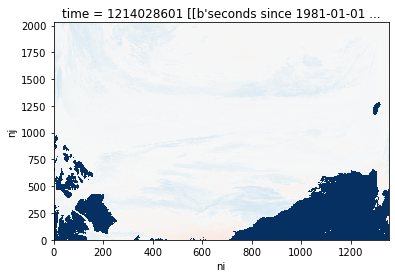

In [43]:
f = s3_fs.open(s3_link, mode='rb')
ds = xr.open_dataset(f, decode_cf=False)
f.close()
display(ds)
ds.sea_surface_temperature.plot()

### Use geolocation of ICESat-2 to define the single transect used to pull coincident ocean data out from array

### Create a plot of the single transect of gridded data 

(bonus: time series) - describe what this means to egress out of the cloud versus pulling the original data down (benefit to processing in the cloud)

## Download MODIS GHRSST data from Cloud

In [ ]:
from shapely.geometry import box

In [ ]:
map_proj = ccrs.PlateCarree()

In [ ]:
def bbox_geometry(boxs, t_crs=ccrs.NorthPolarStereo()):
    '''Generates a shapely.geometry.box object from boxes metadata'''
    lat_min, lon_min, lat_max, lon_max = [float(v) for v in bbox.split()]
    x_min, y_min = t_crs.transform_point(lon_min, lat_min, ccrs.PlateCarree())
    x_max, y_max = t_crs.transform_point(lon_max, lat_max, ccrs.PlateCarree())
    return box(x_min, y_min, x_max, y_max)

bbox_features = []
for granule in modis_granules_meta:
    for bbox in granule['boxes']:
        bbox_features.append(bbox_geometry(bbox))

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180.,180.,60.,90.], ccrs.PlateCarree())
ax.coastlines()
ax.add_geometries([bbox_features[0]], crs=map_proj, alpha=0.3)

---

## Resources (optional)

---

## Conclusion